$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\partial}
    \newcommand{\sentinels}{\mathbf{\boundary}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\linavg}{\bar{\tau}}
    \newcommand{\invvar}{\tau^{IV}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
$$

In [1]:
do_savefig = false
figures_dir = "insert/path/where/figures/should/be/saved/"
;

In [2]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using LinearAlgebra
using Distances
import CSV
import LibGEOS
import Random
using Printf
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/imolk/Library/Julia/alternative_depots/geordd/packages/PyPlot/4wzW1/src/init.jl:192


In [3]:
using Revise
using GeoRDD

# Experiment

In [4]:
function read_matrix(filename)
    df = CSV.read(filename; header=false)
    mat = convert(Matrix{Float64}, df)
    return mat
end

read_matrix (generic function with 1 method)

In [5]:
X_LA = read_matrix("Mississippi_data/X_LA.csv")
X_MS = read_matrix("Mississippi_data/X_MS.csv")
border_XY = read_matrix("Mississippi_data/border.csv")
border = LibGEOS.LineString([border_XY[i,:] for i in 1:size(border_XY,1)])
sentinels = GeoRDD.sentinels(border, 200)
;

In [6]:
n_MS = size(X_MS, 2)
n_LA = size(X_LA, 2)
Y_MS = zeros(n_MS)
Y_LA = zeros(n_LA)
;

In [7]:
k = SEIso(log(100e3), 0.0)
k2 = k + Const(log(100.0))

Type: SumKernel{SEIso{Float64},Const{Float64}}
  Type: SEIso{Float64}, Params: [11.512925464970229, 0.0]  Type: Const{Float64}, Params: [4.605170185988092]

In [8]:
gp_MS = GP(X_MS, Y_MS, MeanZero(), k2, 0.0)
gp_LA = GP(X_LA, Y_LA, MeanZero(), k2, 0.0)
;

In [9]:
Random.seed!(4)
τ = 1.2
gpNull = GeoRDD.make_null(gp_MS, gp_LA)
Ysim = GeoRDD.prior_rand(gpNull)
Ysim .-= mean(Ysim)
Ysim[1:gp_MS.nobs] .+= τ
Ysim_MS = Ysim[1:gp_MS.nobs]
Ysim_LA = Ysim[gp_MS.nobs+1:end]
minY = minimum(Ysim)
maxY = maximum(Ysim)
gp_MS.y = Ysim_MS
gp_LA.y = Ysim_LA
GaussianProcesses.update_mll!(gp_MS)
GaussianProcesses.update_mll!(gp_LA)
;

In [10]:
GeoRDD.pval_invvar_uncalib(gp_MS, gp_LA, sentinels)

0.007199600629108049

In [11]:
GeoRDD.pval_invvar_calib(gp_MS, gp_LA, sentinels)

0.022399059731634266

In [12]:
@time GeoRDD.boot_chi2test(gp_MS, gp_LA, sentinels, 10000)

  1.324420 seconds (1.50 M allocations: 282.606 MiB, 4.88% gc time)


0.0754

In [13]:
@time GeoRDD.boot_chi2test(gp_MS, gp_LA, sentinels, 10000)

  0.924567 seconds (270.43 k allocations: 222.232 MiB, 2.77% gc time)


0.0759

In [14]:
@time GeoRDD.boot_mlltest(gp_MS, gp_LA, 10000)

  0.861830 seconds (1.16 M allocations: 208.877 MiB, 5.80% gc time)


0.0354

## Plot outcomes

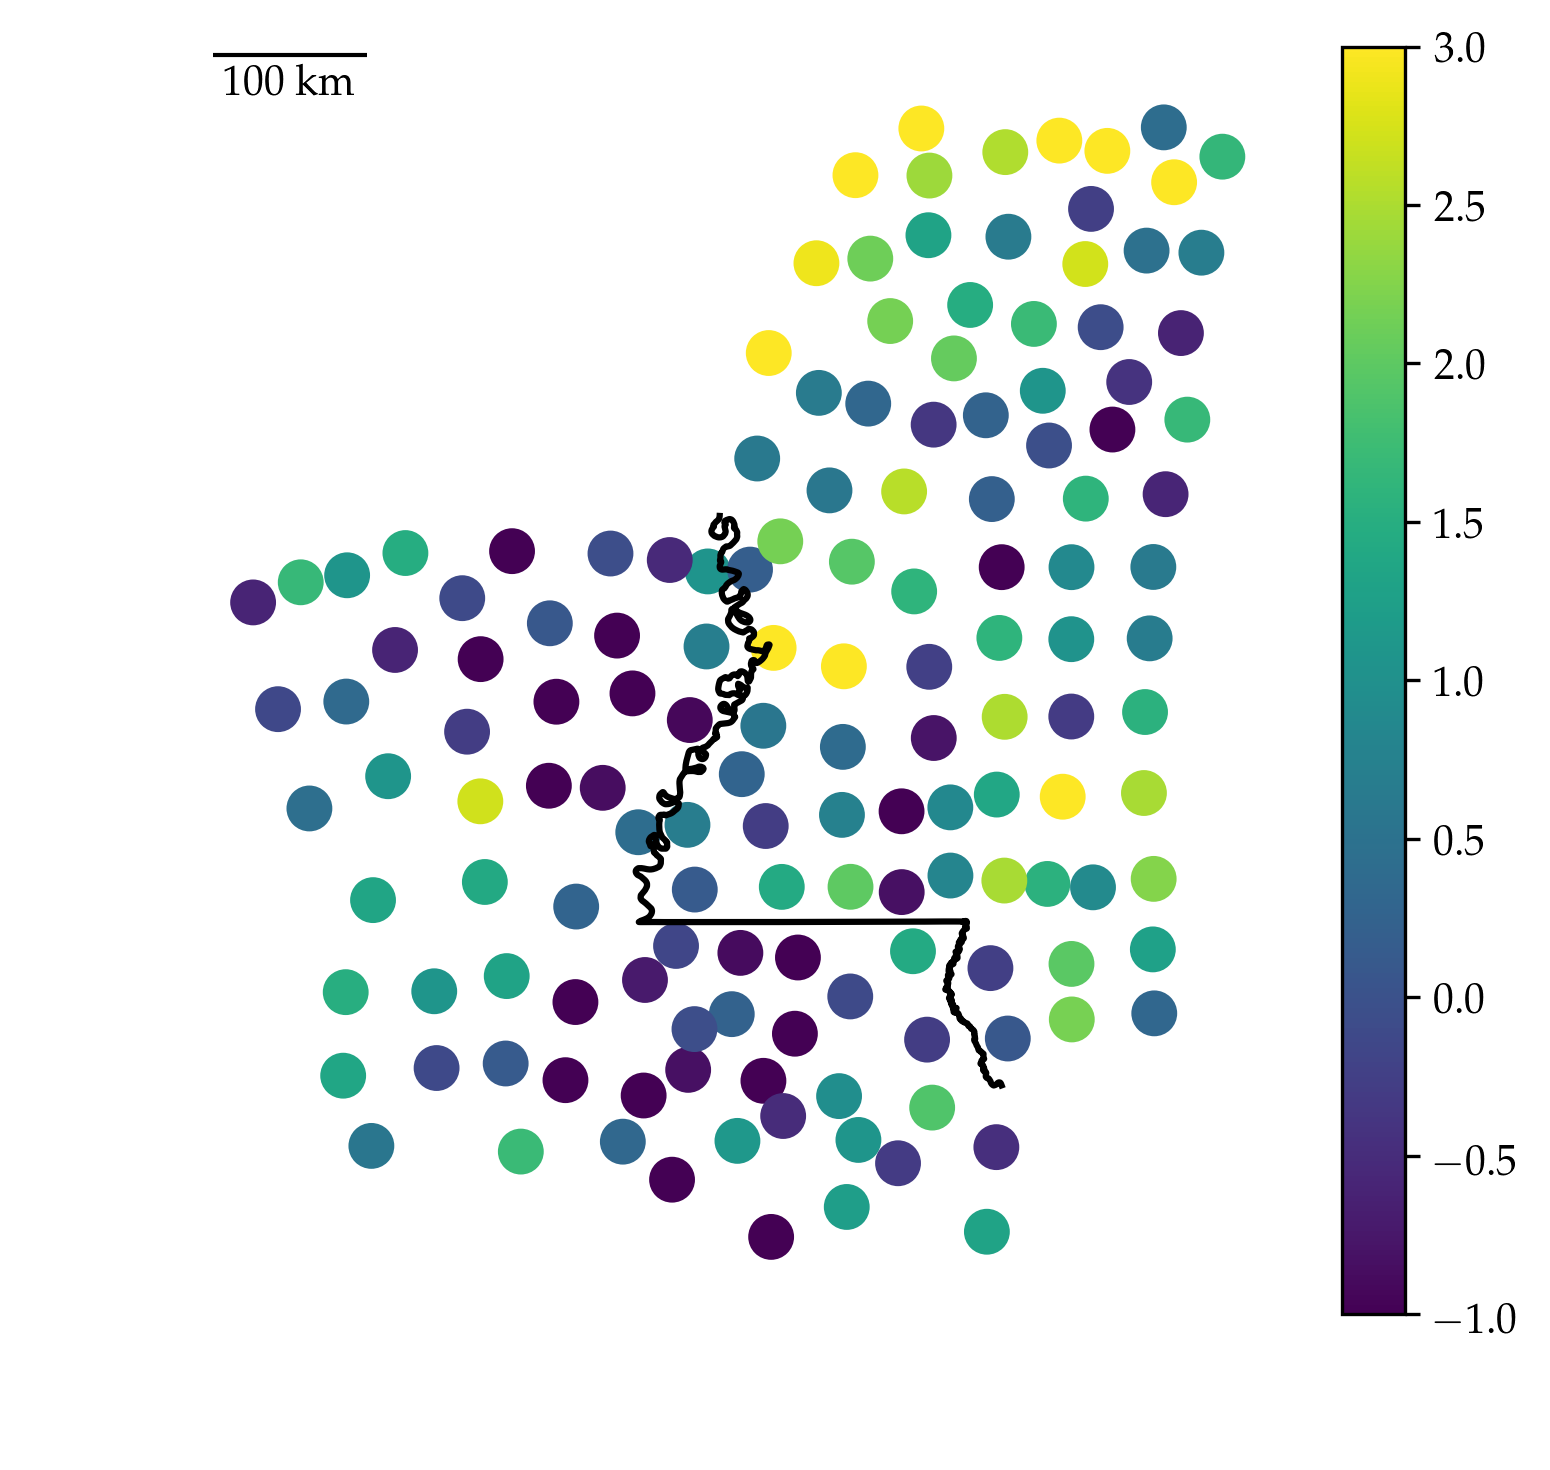

In [15]:
using PyCall
anchored_artists = pyimport("mpl_toolkits.axes_grid1.anchored_artists")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
plt.gcf().set_size_inches(10.0, 5.0)
plt.subplot(1,2,1)
scale=10
# s=scale*(Ysim_LA-minY)+1
plt.scatter(X_LA[1,:], X_LA[2,:], marker="o", c=Ysim_LA, vmin=-1, vmax=3, s=100)
ax = plt.gca()
ax.axis("off")
ax.axes.set_aspect("equal", "datalim")
plt.plot(border_XY[:,1], border_XY[:,2], color="black")
plt.scatter(X_MS[1,:], X_MS[2,:], marker="o", c=Ysim_MS, vmin=-1, vmax=3, s=100)
sizebar = anchored_artists.AnchoredSizeBar(ax.transData, 100*1000, "100 km", 2; frameon=false)
ax.add_artist(sizebar)
plt.colorbar()
if do_savefig
    plt.savefig(joinpath(figures_dir, "mississippi_sim.png"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "mississippi_sim.pdf"), bbox_inches="tight")
end
;

In [16]:
Random.seed!(1)
@time p_invvar_sims = GeoRDD.nsim_invvar_pval_uncalib(gp_MS, gp_LA, sentinels, 100000);

 12.852404 seconds (3.42 M allocations: 2.476 GiB, 2.09% gc time)


In [17]:
@time mLL_sims = let
    gpT = gp_MS
    gpC = gp_LA
    gpNull = GeoRDD.make_null(gpT, gpC)
    GeoRDD.nsim_logP(gp_MS, gp_LA, gpNull, 100_000)
end

mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

  5.085229 seconds (2.80 M allocations: 1.604 GiB, 5.06% gc time)


In [18]:
@time chi_sims_μ = let
    gpT = gp_MS
    gpC = gp_LA
    gpNull = GeoRDD.make_null(gpT, gpC)
    
    GeoRDD.nsim_chi(gp_MS, gp_LA, gpNull, sentinels, 100_000)
end
;

  9.298811 seconds (2.70 M allocations: 2.118 GiB, 2.29% gc time)


# Power

In [19]:
τ=1.2
Random.seed!(1)
@time power_sims = GeoRDD.nsim_power(gp_MS, gp_LA, τ, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000
                  );

 43.192641 seconds (2.28 M allocations: 33.167 GiB, 12.38% gc time)


In [20]:
τnull=0.0
Random.seed!(1)
@time power_sims_null = GeoRDD.nsim_power(gp_MS, gp_LA, τnull, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000
                  );

 42.418971 seconds (1.13 M allocations: 33.114 GiB, 12.18% gc time)


## plot power

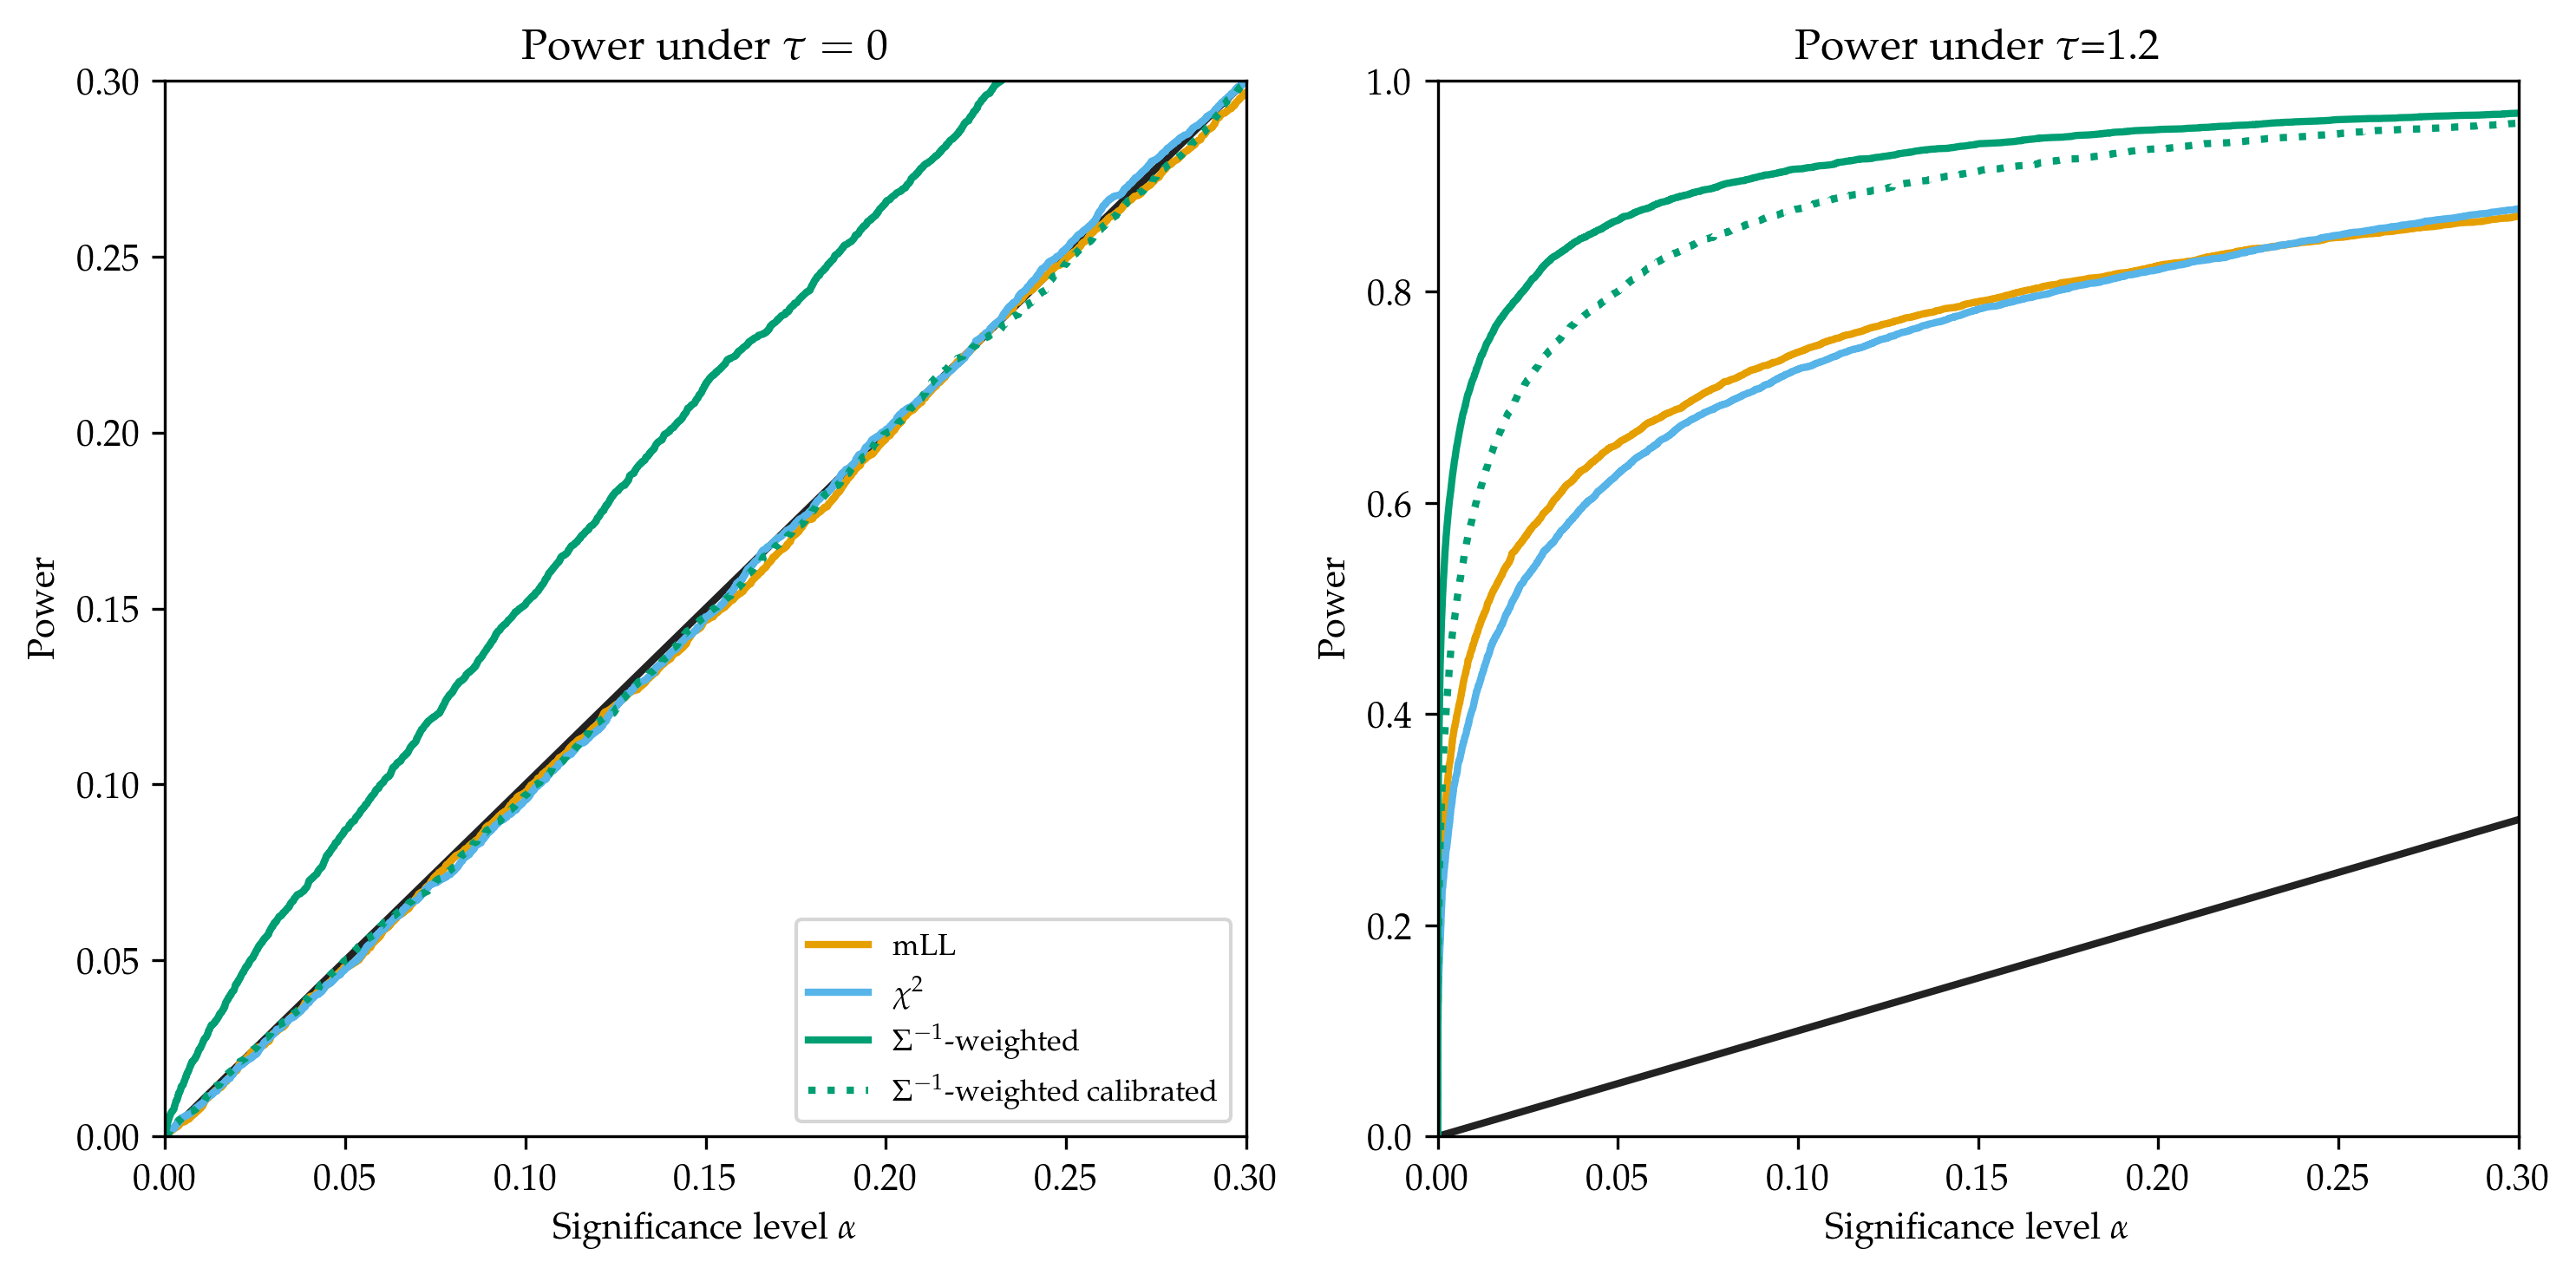

In [21]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
bins=range(0, stop=1.1, length=1000)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims_null]), 
         range(0, stop=1, length=length(power_sims_null)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims_null]), 
         range(0, stop=1, length=length(power_sims_null)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims_null]), 
         range(0, stop=1, length=length(power_sims_null)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims_null]), 
#          range(0, stop=1, length=length(power_sims_null)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims_null]), 
         range(0, stop=1, length=length(power_sims_null)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
plt.legend(loc="lower right", fontsize="small")
plt.title(L"Power under $\tau=0$")
plt.xlim(0,0.3)
plt.ylim(0,0.3)

plt.subplot(1,2,2)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims]), 
         range(0, stop=1, length=length(power_sims)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims]), 
         range(0, stop=1, length=length(power_sims)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims]), 
         range(0, stop=1, length=length(power_sims)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims]), 
#          range(0, stop=1, length=length(power_sims)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims]), 
         range(0, stop=1, length=length(power_sims)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
plt.title(@sprintf("Power under \$\\tau\$=%.1f", τ))
plt.xlim(0,0.3)
plt.ylim(0,1.0)
;

## generate table

In [22]:
import DataFrames
power_df = DataFrames.DataFrame()
power_df.estimator = LaTeXString.([
                        "mLL bootstrap", 
                        raw"\(\chi^2\) bootstrap", 
                        raw"\(\invvar\) uncalibrated", 
                        raw"\(\invvar\) bootstrap calibrated", 
                        raw"\(\invvar\) analytically calibrated"]
                        )
α = 0.05
pval_fmt(pvals, α) = @sprintf("%.2f", mean(p < α for p in pvals))
power_df.null = [pval_fmt((ps[i] for ps in power_sims_null), α) for i in 1:5]
power_df.altv = [pval_fmt((ps[i] for ps in power_sims), α) for i in 1:5]
power_df

,estimator,null,altv
,LaTeXStr…,String,String
1,mLL bootstrap,0.05,0.66
2,\\(\\chi^2\\) bootstrap,0.05,0.63
3,\\(\\invvar\\) uncalibrated,0.09,0.87
4,\\(\\invvar\\) bootstrap calibrated,0.05,0.80
5,\\(\\invvar\\) analytically calibrated,0.05,0.80


In [23]:
print(repr("text/latex", power_df))

\begin{tabular}{r|ccc}
	& estimator & null & altv\\
	\hline
	& LaTeXStr… & String & String\\
	\hline
	1 & mLL bootstrap & 0.05 & 0.66 \\
	2 & \(\chi^2\) bootstrap & 0.05 & 0.63 \\
	3 & \(\invvar\) uncalibrated & 0.09 & 0.87 \\
	4 & \(\invvar\) bootstrap calibrated & 0.05 & 0.80 \\
	5 & \(\invvar\) analytically calibrated & 0.05 & 0.80 \\
\end{tabular}
